## Neural Style Transfer

In [89]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras.applications import VGG19
import copy
from PIL import Image

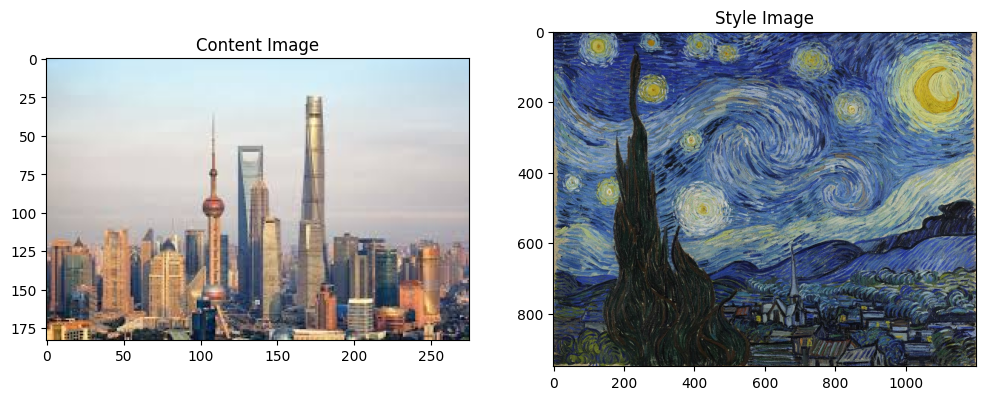

In [90]:
img_content = plt.imread('content.jpg')
img_style = plt.imread('style.jpg')

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display content image in the first subplot
axes[0].imshow(img_content)
axes[0].set_title('Content Image')

# Display style image in the second subplot
axes[1].imshow(img_style)
axes[1].set_title('Style Image');

## Model

Initialize a VGG19 model pretrained on the ImageNet dataset and freeze its weights to prevent further training. Then, encode an input image using this pretrained VGG19 model to extract its feature representations.

In [91]:
vgg = VGG19(include_top=False, weights='imagenet')

In [92]:
vgg.trainble = False

In [93]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

**Style Layer Weights:**

In the STYLE_LAYERS list, each style layer is associated with a weight, indicating its relative importance in influencing the style of the generated image. These weights determine how much each style layer contributes to the overall visual style of the output image during the style transfer process.

In [94]:
STYLE_LAYERS = [
    ('block1_conv1', 0.2),
    ('block2_conv1', 0.2),
    ('block3_conv1', 0.2),
    ('block4_conv1', 0.2),
    ('block5_conv1', 0.2)
]

**Content Layer:**

In the CONTENT_LAYER list, a content layer is specified along with its weight. This content layer is crucial for capturing the content of the input image during the style transfer process.

In [95]:
CONTENT_LAYER = [('block5_conv4', 1)]

In [96]:
def create_model(model, layer_names):
    outputs = [vgg.get_layer(layer[0]).output for layer in layer_names]
    return tf.keras.Model(inputs=model.input, outputs=outputs)


In [97]:
vgg_model_outputs = create_model(vgg, STYLE_LAYERS + CONTENT_LAYER)

## Preprocessing

In [98]:
IMG_SIZE = 400

def preprocess_image(image):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image[tf.newaxis, :]
    return image

In [99]:
img_content = preprocess_image(img_content)
img_style = preprocess_image(img_style)

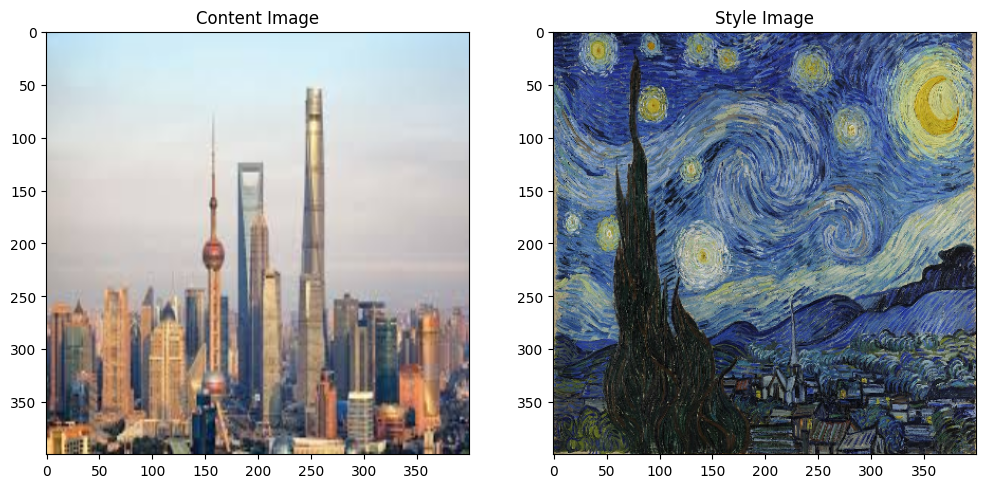

In [100]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Display content image in the first subplot
axes[0].imshow(img_content[0])
axes[0].set_title('Content Image')

# Display style image in the second subplot
axes[1].imshow(img_style[0])
axes[1].set_title('Style Image');

In [101]:
img_content.shape

TensorShape([1, 400, 400, 3])

In [102]:
img_style.shape

TensorShape([1, 400, 400, 3])

## Content and Style Preprocessing:

The content and style images are first converted to the float32 format using **tf.image.convert_image_dtype** and then fed into the **vgg_model_outputs** function to extract their feature representations. These preprocessed images are essential for computing the content and style losses during the neural style transfer process.



In [103]:
preprocessed_content =  tf.Variable(tf.image.convert_image_dtype(img_content, tf.float32))
content = vgg_model_outputs(preprocessed_content)

preprocessed_style =  tf.Variable(tf.image.convert_image_dtype(img_style, tf.float32))
style = vgg_model_outputs(preprocessed_style)

**The final index corresponds to the content activation, while the preceding indices pertain to the style.**

In [104]:
content[-1].shape

TensorShape([1, 25, 25, 512])

In [105]:
len(style[:-1])

5

##Generated Image Initialization:

In this section, the generated image is initialized as a combination of the content image and random noise, with the noise being added to introduce variation.

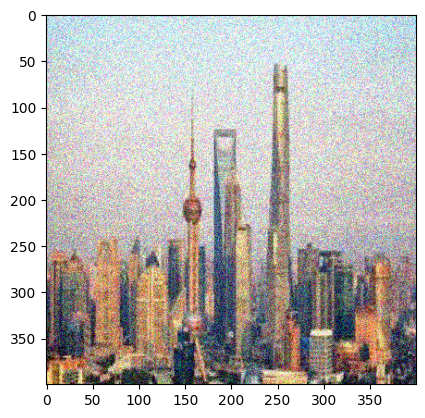

In [106]:
generated_image = tf.image.convert_image_dtype(img_content, tf.float32)
noise = tf.random.uniform(tf.shape(generated_image), -0.25, 0.25)
generated_image = tf.add(generated_image, noise)
generated_image = tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0)
generated_image = tf.Variable(generated_image)
plt.imshow(generated_image[0])

In [107]:
generated_image.shape

TensorShape([1, 400, 400, 3])


## Content Cost Function:

One of the goals of Neural Style Transfer (NST) is to ensure that the content in the generated image $G$ matches the content of the content image $C$. To achieve this, we calculate the content cost function, denoted as $J_{content}(C,G)$, which is defined as:


$$J_{content}(C,G) = \frac{1}{4 \times n_H \times n_W \times n_C} \sum_{\text{all entries}} (a^{(C)} - a^{(G)})^2$$


Here, $n_H, n_W$ and $n_C$ represent the height, width, and number of channels of the chosen hidden layer, respectively. These values appear in a normalization term in the content cost function.


For clarity, $a^{(C)}$ and $a^{(G)}$ denote the 3D volumes corresponding to the activations of the chosen hidden layer. To compute the content cost $J_{content}(C,G)$, it's convenient to unroll these 3D volumes into a 2D matrix. Though technically not necessary for computing $J_{content}$, this unrolling step serves as good practice for similar operations required later for computing the style cost $J_{style}$.

In [108]:
def content_cost_func(generated_output, content_output):

    a_C = content_output[-1]
    a_G = generated_output[-1]
    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    # Reshape 'a_C' and 'a_G'
    a_C_unrolled = tf.reshape(a_C, (-1, n_H * n_W, n_C))
    a_G_unrolled = tf.reshape(a_G, (-1, n_H * n_W, n_C))
    # Compute the content cost
    J_content = (1 / (4 * n_H * n_W * n_C)) * tf.reduce_sum(tf.square(tf.subtract(a_C_unrolled, a_G_unrolled)))

    return J_content

## Gram Matrix:

The style matrix, used in Neural Style Transfer (NST), is also known as a "Gram matrix." In linear algebra, the Gram matrix $G$ of a set of vectors $(v_{1},\dots ,v_{n})$ is defined as the matrix of dot products, where the entries are given by:


$$G_{ij} = v_{i}^T v_{j} = \text{np.dot}(v_{i}, v_{j})$$


In simpler terms, $G_{ij}$ quantifies how similar $v_i$ is to $v_j$. If $v_i$ and $v_j$ are highly similar, you would expect their dot product to be large, resulting in a large value for $G_{ij}$.


In [109]:
def gram_matrix(A):

    GA = tf.matmul(A, tf.transpose(A))
    return GA

## Style Cost Function:

For now, let's focus on using only a single hidden layer $a^{[l]}$. The corresponding style cost for this layer is defined as:

$$J_{style}^{[l]}(S,G) = \frac{1}{4 \times {n_C}^2 \times (n_H \times n_W)^2} \sum_{i=1}^{n_C}\sum_{j=1}^{n_C} (G^{(S)}_{(gram)i,j} - G^{(G)}_{(gram)i,j})^2$$

Here:
- $G_{gram}^{(S)}$ represents the Gram matrix of the "style" image.
- $G_{gram}^{(G)}$ represents the Gram matrix of the "generated" image.

It's important to remember that this cost is computed using the hidden layer activations for a particular hidden layer in the network $a^{[l]}$.


In [110]:
def style_cost_for_layer_func(a_S, a_G):

    _, n_H, n_W, n_C = a_G.get_shape().as_list()
    # Reshape the tensors from (1, n_H, n_W, n_C) to (n_C, n_H * n_W)
    a_S = tf.reshape(tf.transpose(a_S, perm=[0, 3, 1, 2]), (n_C, n_H * n_W))
    a_G = tf.reshape(tf.transpose(a_G, perm=[0, 3, 1, 2]), (n_C, n_H * n_W))

    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    J_style_layer = (1 / (4 * n_C **2 * (n_H * n_W) **2)) * tf.reduce_sum(tf.square(tf.subtract(GS, GG)))

    return J_style_layer


Here's the combined style cost formula:

$$ J_{style}(S,G) = \sum_{l} \lambda^{[l]} J^{[l]}_{style}(S,G) $$

This formula calculates the total style cost by summing up the style costs for all specified layers, each weighted by its corresponding value in `STYLE_LAYERS`.



In [111]:
def style_cost_func(generated_output, style_output, style_layers):

    a_S = style_output[:-1]
    a_G = generated_output[:-1]

    J_style = 0

    for i, weight in zip(range(len(a_S)), style_layers):
      J_style += weight[1] * style_cost_for_layer_func(a_S[i], a_G[i])

    return J_style

## Total Cost

The total cost combines both the content and style costs according to the formula:

$$J(G) = \alpha J_{content}(C,G) + \beta J_{style}(S,G)$$

In [112]:
@tf.function()
def cost_func(J_content, J_style, alpha = 10, beta = 40):

  return alpha * J_content + beta * J_style

In [113]:
def tensor_to_image(tensor):

    tensor = tensor * 255
    tensor = np.array(tensor, dtype=np.uint8)
    if np.ndim(tensor) > 3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
    return Image.fromarray(tensor)

In [114]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

The `train_step` function optimizes a generated image to match the content and style of given content and style images.

1. It computes the content and style costs based on the activations of the generated image.
2. Gradients of the total cost with respect to the generated image are computed.
3. The optimizer updates the generated image using the computed gradients.
4. The generated image is clipped to ensure pixel values remain within the valid range.
5. The function returns the total cost representing the combined content and style loss for the generated image.

In [115]:
@tf.function()
def train_step(generated_image):
    with tf.GradientTape() as tape:

        a_G = vgg_model_outputs(generated_image)

        J_content = content_cost_func(a_G, content)
        J_style = style_cost_func(a_G, style, STYLE_LAYERS)

        J = cost_func(J_content, J_style, 10, 40)

    grad = tape.gradient(J, generated_image)

    optimizer.apply_gradients([(grad, generated_image)])
    generated_image.assign(tf.clip_by_value(generated_image, clip_value_min=0.0, clip_value_max=1.0))
    return J


## Training

Epoch 0 


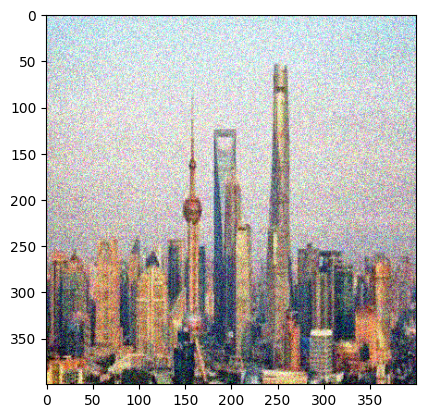

Epoch 2500 


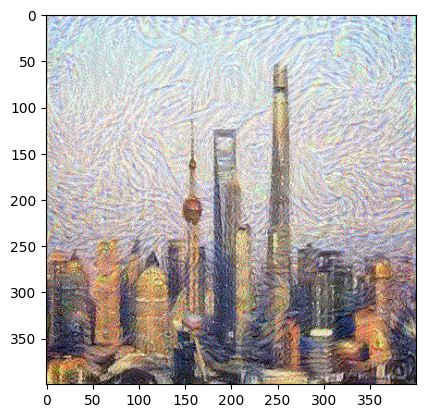

Epoch 5000 


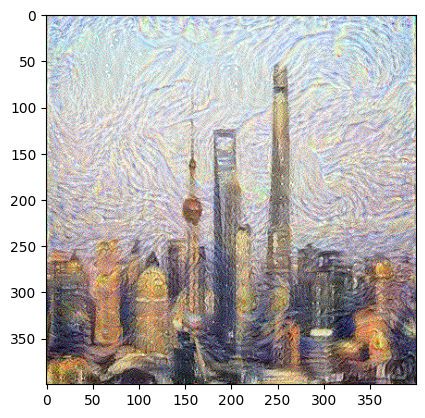

Epoch 7500 


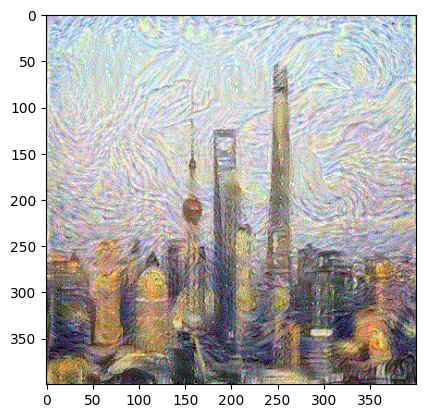

Epoch 10000 


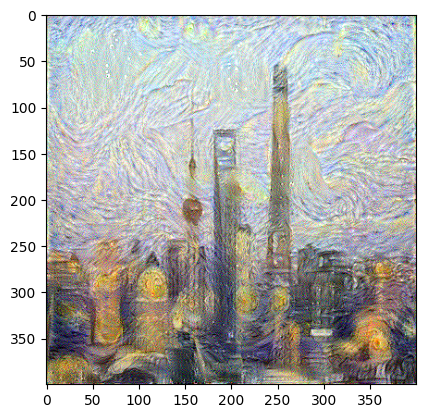

Epoch 12500 


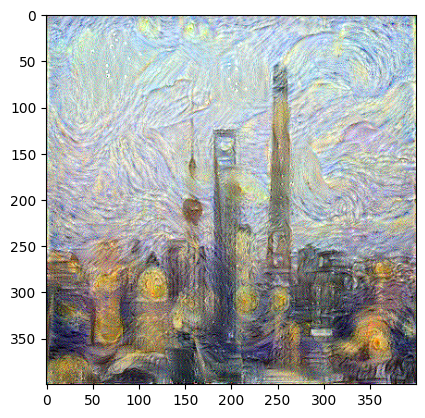

Epoch 15000 


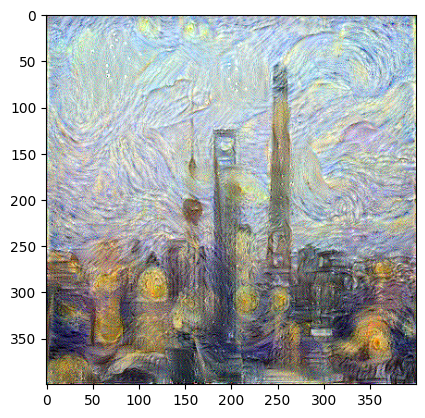

Epoch 17500 


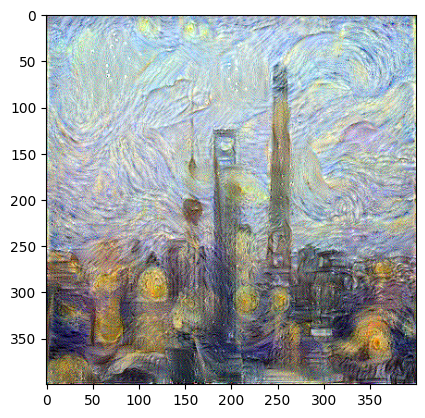

In [116]:
EPOCHS = 20000

for epoch in range(EPOCHS):
    train_step(generated_image)
    if epoch % 2500 == 0:
        print(f"Epoch {epoch} ")
    if epoch % 2500 == 0:
        image = tensor_to_image(generated_image)
        plt.imshow(image)
        plt.show();

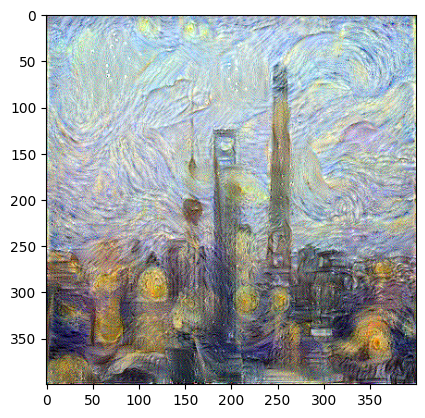

In [117]:
plt.imshow(image)
image.save(f"/content/outputs/image_{epoch}.jpg")
plt.show()